# Assignment 7 - Model 1


### Model 01

- Target
  - Get a functional skeleton of the neural network working which allows for flexibility and scope for improvement unlike Mercedes's F1 car from the last 2 years
  - Apart from Convolution, don't plan on using Fully connected layers and keep a placeholder for Gap layer
- Results
  - Parameters: 75,024
  - Best train accuracy: 99.25%
  - Best test accuracy: 99.24%
- Analyses
  - The model is large in terms of parameters
  - Each Convolution layer is followed by a Relu function
  - There are 6 Convolution layers followed an adaptive average pooling layer
  - For the size of the model accuracy is not impressive, but we are not trying to optimize in any manner

## Library Installation (Optional)


In [1]:
# Where are you running this? Can be either 'local' or 'colab'
model_run_location = "colab"

# # Do you want to install the required packages?
# install_required_packages = False
install_required_packages = False if model_run_location == "local" else True

In [2]:
# # Install any required libraries not present in your working environment

if install_required_packages:
    # # Needed locally and in colab
    # !pip install torchsummary
    # !conda install -c frgfm torchscan

    import sys
    !{sys.executable} -m pip install torchsummary

    # # Only if you want to automate receptive field calculation
    # if model_run_location == 'colab':
    #     !{sys.executable} -m pip install torchscan
    # elif model_run_location == 'local':
    #     %conda install --yes --prefix {sys.prefix} -c frgfm torchscan

    # # Needed locally
    # !conda install -c conda-forge tqdm
    # !conda install -c anaconda ipywidgets

    if model_run_location == 'local':
        %conda install --yes --prefix {sys.prefix} -c conda-forge tqdm
        %conda install --yes --prefix {sys.prefix} -c anaconda ipywidgets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Mount Drive


In [3]:
# Mount google drive if running on colab
if model_run_location == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/WorkSpace/era-v1/Session 07/Submission

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/WorkSpace/era-v1/Session 07/Submission


## Import Libraries


In [4]:
# Import necessary modules (external libs)
from __future__ import print_function

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms

In [5]:
# Import user defined modules
from model import Model01 as Net, plot_train_test_metrics, test_model, train_model
from utils import download_mnist_data, get_device, plot_sample_training_images

In [6]:
# Functionality to check cuda support and create device is now moved to utils.py
device_support, device = get_device()
print(f"Device created with {device_support}!")

Device created with cuda!


## Data Transformations


In [7]:
# Train and test data transformation steps now moved to apply_mnist_image_transformations()


def apply_mnist_image_transformations():
    """
    Function to apply the required transformations to the MNIST dataset.
    """
    # Apply the required transformations to the MNIST dataset
    train_transforms = transforms.Compose(
        [
            # Convert the images to tensors
            # normalize the images with mean and standard deviation from the whole dataset
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    )

    # Test data transformations
    test_transforms = transforms.Compose(
        # Convert the images to tensors
        # normalize the images with mean and standard deviation from the whole dataset
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )

    return train_transforms, test_transforms


train_transforms, test_transforms = apply_mnist_image_transformations()

## Train/Test Split


In [8]:
data_path = "../data"
print(f"Train and test data path: {data_path}")

train_data, test_data = download_mnist_data(
    data_path, train_transforms, test_transforms
)

Train and test data path: ../data


## Dataloaders


In [9]:
# Set seed value for reproducibility
seed = 1

# For reproducibility
torch.manual_seed(seed)

if device_support == "cuda":
    torch.cuda.manual_seed(seed)

batch_size = 32

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(
    shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True
)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Sample Training Images


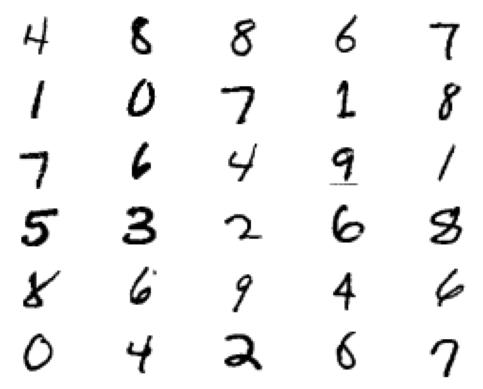

In [10]:
# Get a batch of training data from train_loader
batch_data, batch_label = next(iter(train_loader))

# Plot 60 sample images from the training data along with their labels
# plot_sample_training_images() imported from utils.py
fig = plot_sample_training_images(batch_data, num_images=30)
plt.show()

## Model Summary


In [11]:
# Model class is imported from model.py
# Send the model to device
model = Net().to(device)
# Print the model summary by specifying the input size
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 32, 22, 22]           9,216
              ReLU-6           [-1, 32, 22, 22]               0
            Conv2d-7           [-1, 64, 20, 20]          18,432
              ReLU-8           [-1, 64, 20, 20]               0
            Conv2d-9           [-1, 64, 18, 18]          36,864
             ReLU-10           [-1, 64, 18, 18]               0
           Conv2d-11           [-1, 10, 16, 16]           5,760
AdaptiveAvgPool2d-12             [-1, 10, 1, 1]               0
Total params: 75,024
Trainable params: 75,024
Non-trainable params: 0
---------------------------------

## Metric Initialisation


In [12]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

## Train and Test


In [13]:
# Create optimizer and scheduler
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# Specify the number of epochs
num_epochs = 15

for epoch in range(1, num_epochs + 1):
    if epoch == 1:
        print(f"\n\nBatch size: {batch_size}, Total epochs: {num_epochs}\n\n")

    # Print the current epoch
    print(f"Epoch {epoch}")
    # Train the model
    train_model(model, device, train_loader, optimizer, train_acc, train_losses)
    # Test the model
    test_model(model, device, test_loader, test_acc, test_losses)
    # Line break before next epoch
    print("\n")



Batch size: 32, Total epochs: 15


Epoch 1


Train: Loss=0.2691, Batch_id=1874, Accuracy=67.41: 100%|██████████| 1875/1875 [00:37<00:00, 50.08it/s]


Test set: Average loss: 0.1843, Accuracy: 9427/10000 (94.27%)


Epoch 2


Train: Loss=0.1208, Batch_id=1874, Accuracy=95.89: 100%|██████████| 1875/1875 [00:29<00:00, 63.81it/s]


Test set: Average loss: 0.0792, Accuracy: 9776/10000 (97.76%)


Epoch 3


Train: Loss=0.0436, Batch_id=1874, Accuracy=97.50: 100%|██████████| 1875/1875 [00:29<00:00, 63.62it/s]


Test set: Average loss: 0.0557, Accuracy: 9818/10000 (98.18%)


Epoch 4


Train: Loss=0.0110, Batch_id=1874, Accuracy=98.04: 100%|██████████| 1875/1875 [00:29<00:00, 62.51it/s]


Test set: Average loss: 0.0519, Accuracy: 9835/10000 (98.35%)


Epoch 5


Train: Loss=0.3298, Batch_id=1874, Accuracy=98.36: 100%|██████████| 1875/1875 [00:29<00:00, 63.88it/s]


Test set: Average loss: 0.0393, Accuracy: 9868/10000 (98.68%)


Epoch 6


Train: Loss=0.0012, Batch_id=1874, Accuracy=98.56: 100%|██████████| 1875/1875 [00:28<00:00, 65.03it/s]


Test set: Average loss: 0.0406, Accuracy: 9868/10000 (98.68%)


Epoch 7


Train: Loss=0.0464, Batch_id=1874, Accuracy=98.75: 100%|██████████| 1875/1875 [00:29<00:00, 64.50it/s]


Test set: Average loss: 0.0344, Accuracy: 9883/10000 (98.83%)


Epoch 8


Train: Loss=0.0028, Batch_id=1874, Accuracy=98.79: 100%|██████████| 1875/1875 [00:31<00:00, 59.89it/s]


Test set: Average loss: 0.0342, Accuracy: 9881/10000 (98.81%)


Epoch 9


Train: Loss=0.0964, Batch_id=1874, Accuracy=98.93: 100%|██████████| 1875/1875 [00:29<00:00, 63.62it/s]


Test set: Average loss: 0.0294, Accuracy: 9903/10000 (99.03%)


Epoch 10


Train: Loss=0.0030, Batch_id=1874, Accuracy=99.02: 100%|██████████| 1875/1875 [00:29<00:00, 63.74it/s]


Test set: Average loss: 0.0280, Accuracy: 9910/10000 (99.10%)


Epoch 11


Train: Loss=0.0042, Batch_id=1874, Accuracy=99.05: 100%|██████████| 1875/1875 [00:28<00:00, 64.87it/s]


Test set: Average loss: 0.0331, Accuracy: 9898/10000 (98.98%)


Epoch 12


Train: Loss=0.0576, Batch_id=1874, Accuracy=99.11: 100%|██████████| 1875/1875 [00:29<00:00, 63.18it/s]


Test set: Average loss: 0.0399, Accuracy: 9857/10000 (98.57%)


Epoch 13


Train: Loss=0.0025, Batch_id=1874, Accuracy=99.18: 100%|██████████| 1875/1875 [00:29<00:00, 62.63it/s]


Test set: Average loss: 0.0322, Accuracy: 9898/10000 (98.98%)


Epoch 14


Train: Loss=0.0051, Batch_id=1874, Accuracy=99.22: 100%|██████████| 1875/1875 [00:29<00:00, 62.82it/s]


Test set: Average loss: 0.0250, Accuracy: 9924/10000 (99.24%)


Epoch 15


Train: Loss=0.0124, Batch_id=1874, Accuracy=99.25: 100%|██████████| 1875/1875 [00:31<00:00, 59.05it/s]


Test set: Average loss: 0.0274, Accuracy: 9918/10000 (99.18%)




## Metrics


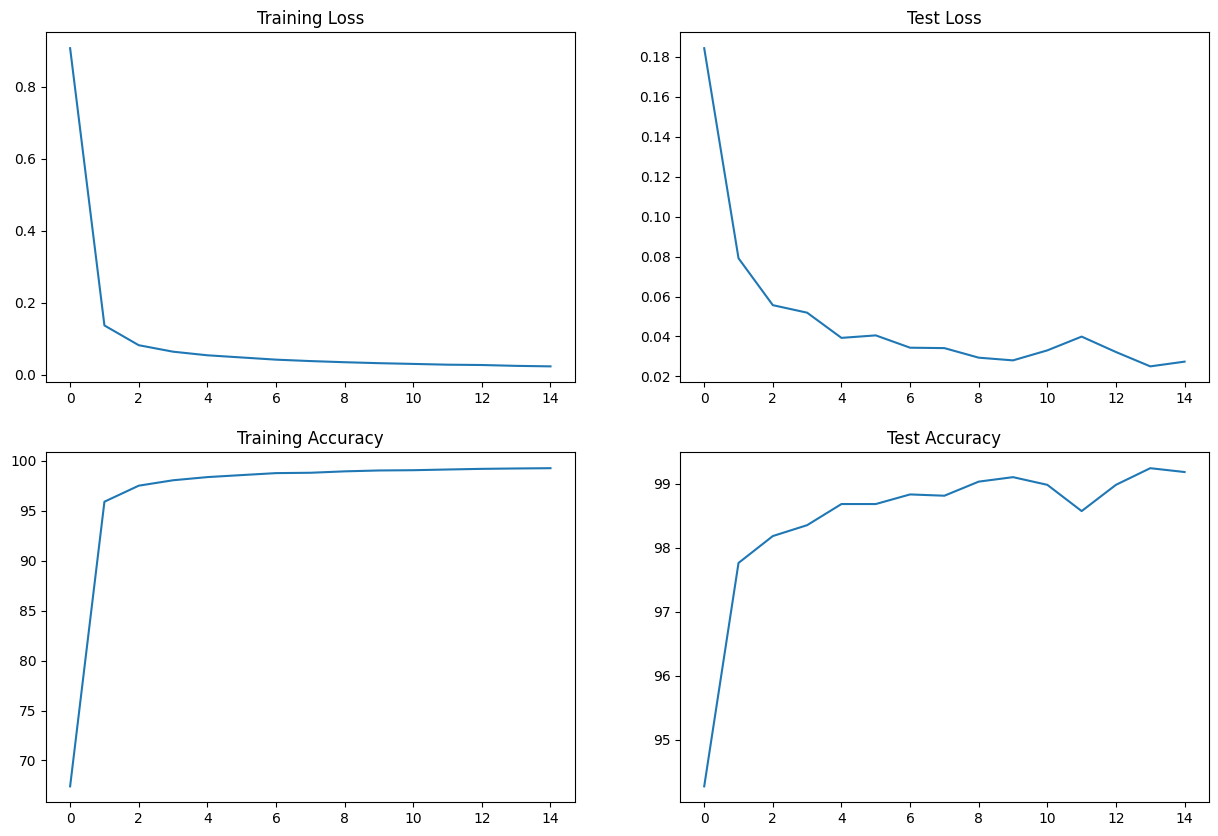

In [14]:
# Plot the accuracy and loss graphs using data and plot_train_test_metrics() from model.py
fig, axs = plot_train_test_metrics(train_losses, train_acc, test_losses, test_acc)
plt.show()